## STEP 1: Title & Problem Statement
# Trader Behavior vs Bitcoin Market Sentiment

## Problem Statement
The objective of this analysis is to understand how Bitcoin market sentiment,
measured using the Fear & Greed Index, impacts trader behavior and performance.

By combining market sentiment data with historical trade data, we aim to uncover
behavioral patterns such as risk-taking, overtrading, and profitability under
different emotional market conditions.

## STEP 2: Import Required Libraries

In [3]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings for better readability
pd.set_option('display.max_columns', None)



## Step 3: Data Loading

Two datasets are used in this analysis:
1. Bitcoin Fear & Greed Index – represents overall market sentiment.
2. Historical Trader Data – contains executed trades and realized PnL.

Both datasets are loaded and inspected to understand their structure.

In [4]:
# Load Fear & Greed Index data
# This dataset captures overall Bitcoin market sentiment on a daily basis
fear_df = pd.read_csv("fear_greed_index.csv")

# Load historical trader data
# This dataset contains actual executed trades and their PnL
trades_df = pd.read_csv("historical_data.csv")


## Step 4: Initial Data Understanding

Before cleaning and analysis, it is important to understand:
- Available columns
- Data types
- Missing values


In [5]:
# Inspect Fear & Greed dataset
fear_df.info()
fear_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [11]:
# Inspect trader dataset
trades_df.info()
trades_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27932 entries, 0 to 27931
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           27932 non-null  object 
 1   Coin              27932 non-null  object 
 2   Execution Price   27932 non-null  float64
 3   Size Tokens       27932 non-null  float64
 4   Size USD          27932 non-null  float64
 5   Side              27932 non-null  object 
 6   Timestamp IST     27932 non-null  object 
 7   Start Position    27932 non-null  float64
 8   Direction         27932 non-null  object 
 9   Closed PnL        27932 non-null  float64
 10  Transaction Hash  27932 non-null  object 
 11  Order ID          27931 non-null  float64
 12  Crossed           27931 non-null  object 
 13  Fee               27931 non-null  float64
 14  Trade ID          27931 non-null  float64
 15  Timestamp         27931 non-null  float64
dtypes: float64(9), object(7)
memory usage: 3

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


## Step 5: Data Cleaning & Preparation

This step ensures both datasets are aligned temporally and contain
only relevant and reliable records for analysis.


## STEP 5.1: Filter Relevant Trades (BTC Only)

In [30]:
# Restrict analysis to Bitcoin-related trades only
# This ensures alignment with Bitcoin Fear & Greed Index
trades_df = trades_df[trades_df['Coin'].str.contains('BTC', na=False)].copy()


## STEP 5.2: Date Handling

In [32]:
# Convert sentiment date to datetime (daily frequency)
fear_df['date'] = pd.to_datetime(fear_df['date']).dt.date

# Convert trade timestamp to datetime
trades_df['Timestamp IST'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)

# Extract date for merging with sentiment data
trades_df['date'] = trades_df['Timestamp IST'].dt.date


## STEP 5.3: Handle Missing Values

In [33]:
# Remove trades where Closed PnL is missing
# Such rows cannot contribute to performance analysis
trades_df = trades_df.dropna(subset=['Closed PnL'])


## Step 6: Feature Engineering

New features are created to better capture trader behavior and performance.
Since leverage is not directly available, position size is used as a proxy
for risk exposure.


In [34]:
# Flag to indicate profitable trades
trades_df['is_profit'] = trades_df['Closed PnL'] > 0

# Absolute PnL to measure loss severity
trades_df['abs_pnl'] = trades_df['Closed PnL'].abs()

# Position size as a proxy for risk-taking behavior
trades_df['risk_size'] = trades_df['Size USD']


## STEP 7: Merge Datasets

Trader data is merged with market sentiment data at a daily level
to analyze how sentiment influences trading behavior.

In [35]:
# Merge trader data with sentiment data
merged_df = trades_df.merge(
    fear_df[['date', 'classification', 'value']],
    on='date',
    how='left'
)

# Verify sentiment coverage
merged_df['classification'].value_counts()


,count
classification,
Fear,5697
Greed,3732
Neutral,2282
Extreme Greed,1965
Extreme Fear,328


## Step 8: Exploratory Data Analysis (EDA)

This section analyzes how trader performance, risk-taking behavior,
and trading activity vary across different Bitcoin market sentiment regimes.

Instead of relying only on averages, distribution-based and multi-metric
visualizations are used to capture behavioral patterns more accurately.

**Scaling Approach:**  
Axis limits and scales are chosen based on data distributions
(using percentiles and log scaling) to reduce distortion from extreme outliers
while preserving underlying patterns.


### Analysis 1: Profitability Distribution vs Market Sentiment

**Objective:**  
To understand how the distribution of profits and losses varies
across different market sentiment regimes.

**Why this matters:**  
Average PnL can hide extreme losses. Distribution-based visualization
highlights downside risk during emotionally driven markets.

**Visualization Used:**  
Violin plot to capture distribution, density, and median.


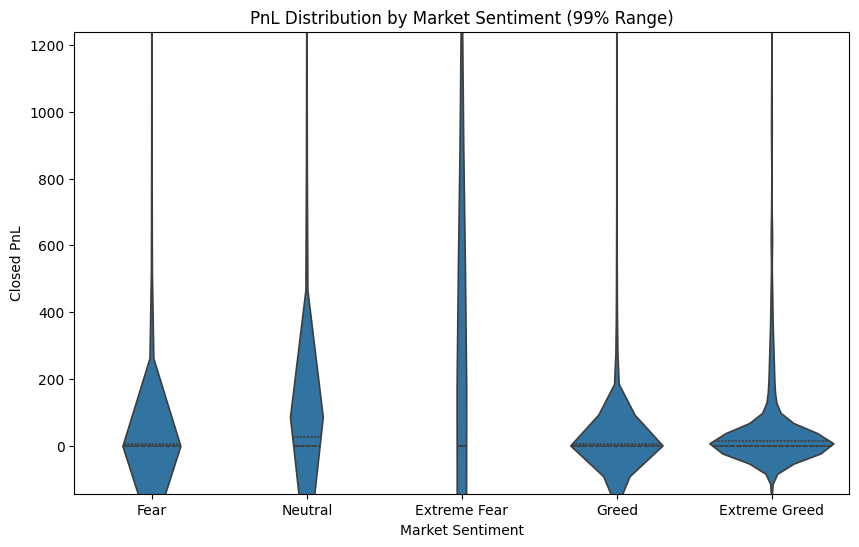

In [40]:
# Percentile-based scaling to reduce impact of extreme PnL outliers
lower, upper = merged_df['Closed PnL'].quantile([0.01, 0.99])

plt.figure(figsize=(10,6))
sns.violinplot(
    x='classification',
    y='Closed PnL',
    data=merged_df,
    inner='quartile'
)

plt.ylim(lower, upper)
plt.title('PnL Distribution by Market Sentiment (99% Range)')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()


### Analysis 2: Trading Activity vs Win Rate

**Objective:**  
To compare trading activity with performance consistency
under different sentiment regimes.

**Why this matters:**  
Higher trading activity does not necessarily translate
into better performance.

**Visualization Used:**  
Dual-axis chart to show quantity (trade count) vs quality (win rate).


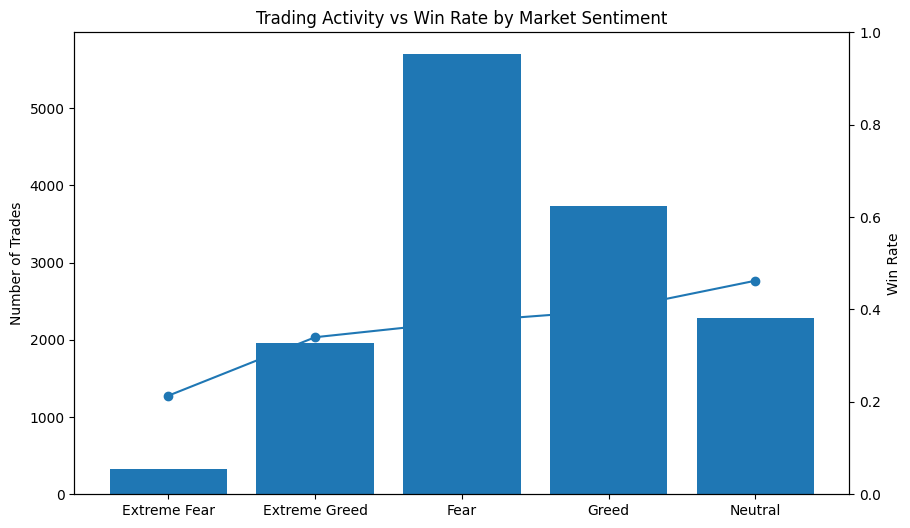

In [41]:
trade_count = merged_df['classification'].value_counts().sort_index()
win_rate = merged_df.groupby('classification')['is_profit'].mean().sort_index()

fig, ax1 = plt.subplots(figsize=(10,6))

# Trade count (activity)
ax1.bar(trade_count.index, trade_count.values)
ax1.set_ylabel('Number of Trades')

# Win rate (performance)
ax2 = ax1.twinx()
ax2.plot(win_rate.index, win_rate.values, marker='o')
ax2.set_ylabel('Win Rate')
ax2.set_ylim(0, 1)  # Natural probability range

plt.title('Trading Activity vs Win Rate by Market Sentiment')
plt.show()


### Analysis 3: Risk-Taking Behavior by Market Sentiment

**Objective:**  
To analyze how trader risk appetite changes with market sentiment.

**Metric Used:**  
Position size (USD) as a proxy for risk exposure.

**Visualization Used:**  
Box plot with log scaling to handle skewed risk distributions.


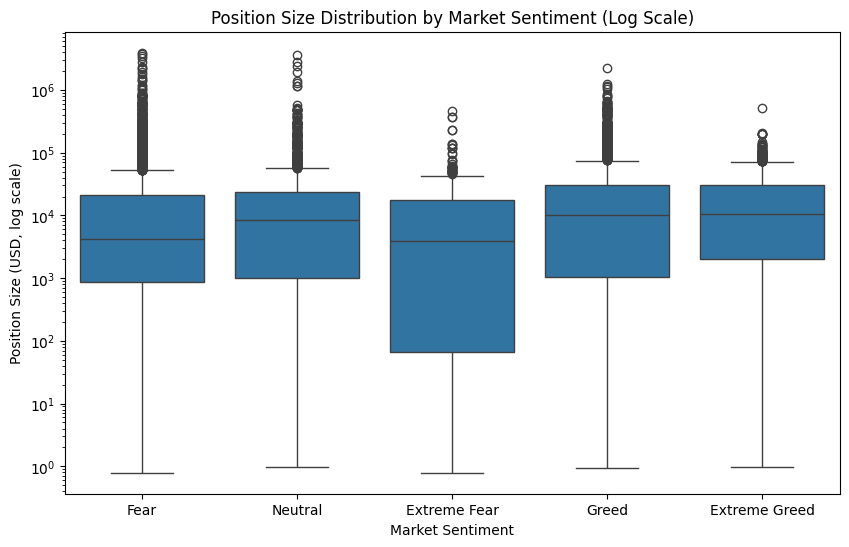

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='classification',
    y='risk_size',
    data=merged_df
)

plt.yscale('log')
plt.title('Position Size Distribution by Market Sentiment (Log Scale)')
plt.xlabel('Market Sentiment')
plt.ylabel('Position Size (USD, log scale)')
plt.show()


### Analysis 4: Loss Severity Across Market Sentiment

**Objective:**  
To evaluate how severe losses are during different market sentiment regimes.

**Why this matters:**  
Effective risk management focuses more on controlling downside
than maximizing upside.

**Visualization Used:**  
Bar chart with percentile-based scaling for clarity.


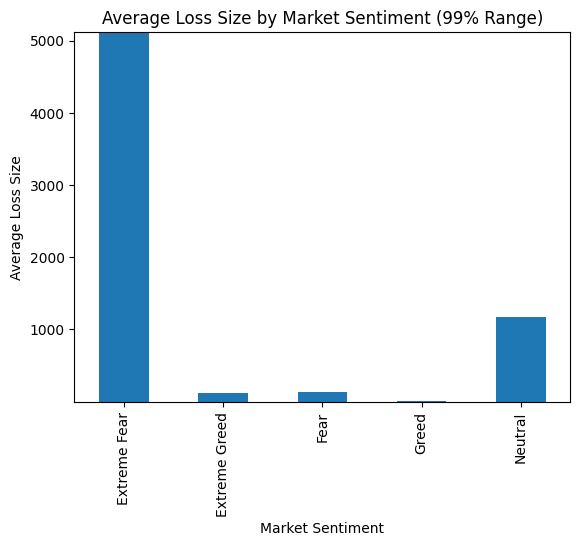

In [45]:
loss_df = merged_df[merged_df['Closed PnL'] < 0]

# Percentile-based scaling for loss severity
lower, upper = loss_df['abs_pnl'].quantile([0.01, 0.99])

loss_df.groupby('classification')['abs_pnl'].mean().plot(
    kind='bar',
    title='Average Loss Size by Market Sentiment (99% Range)'
)

plt.ylim(lower, upper)
plt.ylabel('Average Loss Size')
plt.xlabel('Market Sentiment')
plt.show()


### Analysis 5: Risk Exposure vs Trade Outcome

**Objective:**  
To examine the relationship between risk exposure and trade outcomes
under different market sentiment regimes.

**Why this matters:**  
It reveals whether higher risk is being rewarded or penalized
during emotional market phases.

**Visualization Used:**  
Scatter plot with sentiment-based coloring and data-driven scaling.

**Note on Interpretation:**  
This visualization is intended as a supporting analysis to illustrate
risk–reward dispersion and overall directional trends rather than
provide a single aggregated performance metric.



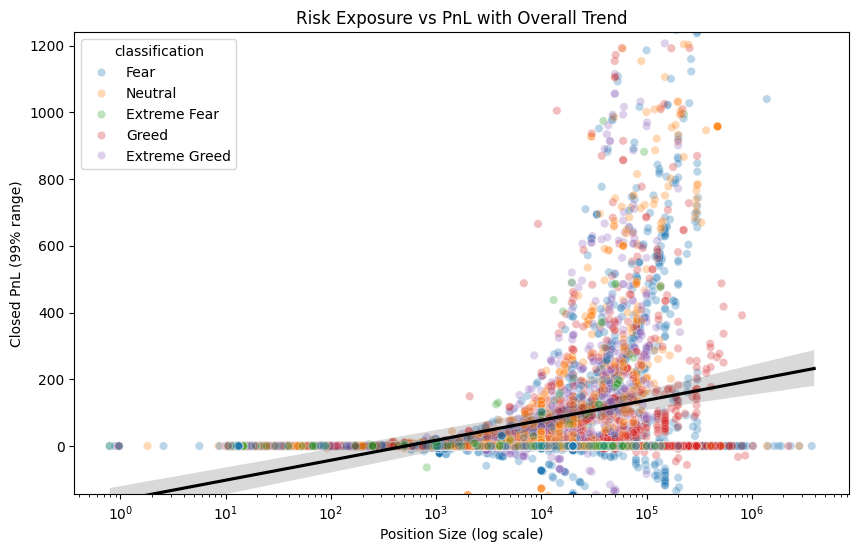

In [48]:
# Percentile-based scaling for PnL
lower, upper = merged_df['Closed PnL'].quantile([0.01, 0.99])

plt.figure(figsize=(10,6))

# Scatter plot for individual trades
sns.scatterplot(
    data=merged_df,
    x='risk_size',
    y='Closed PnL',
    hue='classification',
    alpha=0.3
)

# Overall trend line (risk vs outcome)
sns.regplot(
    data=merged_df,
    x='risk_size',
    y='Closed PnL',
    scatter=False,
    color='black',
    logx=True
)

plt.xscale('log')
plt.ylim(lower, upper)

plt.title('Risk Exposure vs PnL with Overall Trend')
plt.xlabel('Position Size (log scale)')
plt.ylabel('Closed PnL (99% range)')
plt.show()


## Step 9: Summary of EDA Findings

- Greed-driven market conditions exhibit wider PnL distributions and heavier downside risk.
- Trading activity increases during Greed phases, while win rates tend to decline.
- Traders take larger position sizes during positive sentiment, indicating elevated risk-taking behavior.
- Losses are more severe during Greed periods compared to Fear-driven markets.
- Higher risk exposure does not consistently translate into better trade outcomes.



## Step 10: Conclusion & Business Implications

This analysis demonstrates that Bitcoin market sentiment has a strong and
measurable influence on trader behavior and performance.

Greed-driven markets encourage higher trading activity and increased risk-taking,
often resulting in lower win rates and larger losses. In contrast, Fear-driven
markets promote more disciplined trading behavior with relatively stable outcomes.

### Business Implications

These findings suggest that incorporating sentiment-aware risk controls—such as
limiting position sizes and trade frequency during Greed phases—can help reduce
downside risk and improve overall trading performance.

Market sentiment can therefore serve as a valuable input for designing
risk management frameworks and smarter, behavior-aware trading strategies.
